# California Ev Fiyatları İçin Regresyon Modeli 

In [1]:
# Aynı hücre içerisinde birden fazla çıktı yazdırabilmek için. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
# Notebook'un genişliğini tarayıcı penceresinin tam genişliğine ayarlamak için bu kodu kullandım. Bu sayede dataframe'leri daha net görüntüleyebildim.

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Gerekli kütüphaneler.
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Bu kod, Apache Spark'ı kullanarak bir SparkSession oluşturur. Spark'da dataframe'lerle çalışmaya başlamadan önce SparkSession oluşturulması gerekir.

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Project').getOrCreate()

In [5]:
spark

# Verilerin Yüklenmesi

In [6]:
df = spark.read.csv('housing.csv',header=True, inferSchema=True)

df.show(10,truncate=False)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|-122.23  |37.88   |41.0              |880.0      |129.0         |322.0     |126.0     |8.3252       |452600.0          |NEAR BAY       |
|-122.22  |37.86   |21.0              |7099.0     |1106.0        |2401.0    |1138.0    |8.3014       |358500.0          |NEAR BAY       |
|-122.24  |37.85   |52.0              |1467.0     |190.0         |496.0     |177.0     |7.2574       |352100.0          |NEAR BAY       |
|-122.25  |37.85   |52.0              |1274.0     |235.0         |558.0     |219.0     |5.6431       |341300.0          |NEAR BAY       |
|-122.25  |37.85   |52.0          

# Verilerin Çeşitli Spark Fonksiyonları Kullanılarak İncelenmesi

### describe() veri setinin temel istatiksel özelliklerini gösterir. Truncate parametresi gösterilen her değerin uzunluğunu 9 karakterle sınırlar.

In [7]:
df.describe().show(truncate=9)

+-------+---------+---------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|summary|longitude| latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+-------+---------+---------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  count|    20640|    20640|             20640|      20640|         20433|     20640|     20640|        20640|             20640|          20640|
|   mean|-119.5...|35.631...|         28.639...|  2635.7...|     537.87...| 1425.4...| 499.53...|    3.8706...|         206855...|           NULL|
| stddev|2.0035...|2.1359...|         12.585...|  2181.6...|     421.38...| 1132.4...| 382.32...|    1.8998...|         115395...|           NULL|
|    min|  -124.35|    32.54|               1.0|        2.0|           1.0|       3.0|       1.0|       0.4999|       

### Yukarıda yapılan işlem bu sefer de summary() metodu ile yapıldı.

In [8]:
df.select("longitude", "latitude", "housing_median_age","total_rooms", "total_bedrooms","population", "median_income", "median_house_value","households").summary("count","min","max","stddev","mean").show(truncate=13)

+-------+-------------+-------------+------------------+-------------+--------------+-------------+-------------+------------------+-------------+
|summary|    longitude|     latitude|housing_median_age|  total_rooms|total_bedrooms|   population|median_income|median_house_value|   households|
+-------+-------------+-------------+------------------+-------------+--------------+-------------+-------------+------------------+-------------+
|  count|        20640|        20640|             20640|        20640|         20433|        20640|        20640|             20640|        20640|
|    min|      -124.35|        32.54|               1.0|          2.0|           1.0|          3.0|       0.4999|           14999.0|          1.0|
|    max|      -114.31|        41.95|              52.0|      39320.0|        6445.0|      35682.0|      15.0001|          500001.0|       6082.0|
| stddev|2.00353172...|2.13595239...|     12.5855576...|2181.61525...| 421.385070...|1132.46212...|1.89982171...|     

### Veri setinin columnları:

In [9]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

### Column'lar ve veri türleri:

In [10]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



### Veri setindeki satırların sayısı:

In [11]:
df.count()

20640

### Ocean_proximity column'undaki unique değerler:

In [12]:
df.select("ocean_proximity").distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



### Ocean_proximity column'undaki unique değerler ve adetleri:

In [13]:
ocean_counts = df.groupBy("ocean_proximity").count().orderBy(col("count").desc())
ocean_counts.show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|      <1H OCEAN| 9136|
|         INLAND| 6551|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|         ISLAND|    5|
+---------------+-----+



### Bar plot ile bu değerleri görselleştirildi .Pyspark'da doğrudan görselleştirme metodları bulunmamaktadır. Bu yüzden veri setini pandas dataframe'e dönüştürerek ilerlenildi.. 

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='ocean_proximity', ylabel='count'>

Text(0.5, 1.0, 'Ocean Proximity')

Text(0, 0.5, 'Counts')

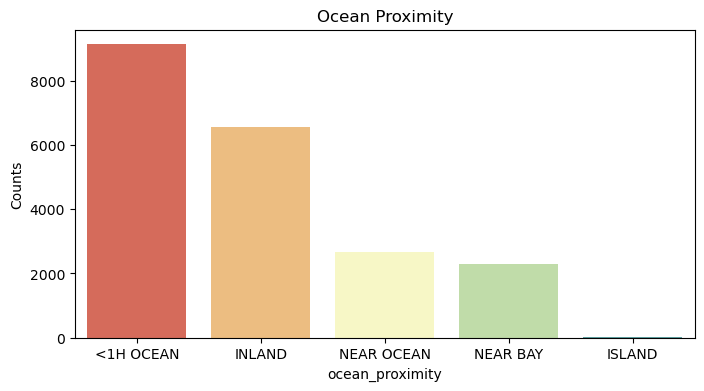

In [14]:
ocean_counts = ocean_counts.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(x="ocean_proximity", y="count", data=ocean_counts,palette='Spectral')
plt.title('Ocean Proximity')
plt.ylabel('Counts')
plt.show()

<Figure size 2000x1000 with 0 Axes>

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

<Figure size 2000x1000 with 0 Axes>

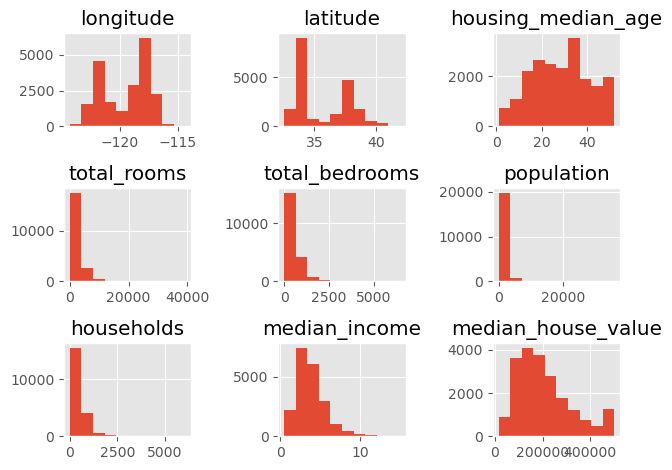

In [15]:
plt.style.use('ggplot')
pandas_df=df.toPandas()
plt.figure(figsize = (20,10))
pandas_df.hist()
plt.tight_layout()
plt.show()

### Veri setinin dağılımını görselleştirmek için histogram plot kullanıldı.

<Axes: xlabel='longitude', ylabel='Count'>

<Axes: xlabel='latitude', ylabel='Count'>

<Axes: xlabel='housing_median_age', ylabel='Count'>

<Axes: xlabel='total_rooms', ylabel='Count'>

<Axes: xlabel='total_bedrooms', ylabel='Count'>

<Axes: xlabel='population', ylabel='Count'>

<Axes: xlabel='households', ylabel='Count'>

<Axes: xlabel='median_income', ylabel='Count'>

<Axes: xlabel='median_house_value', ylabel='Count'>

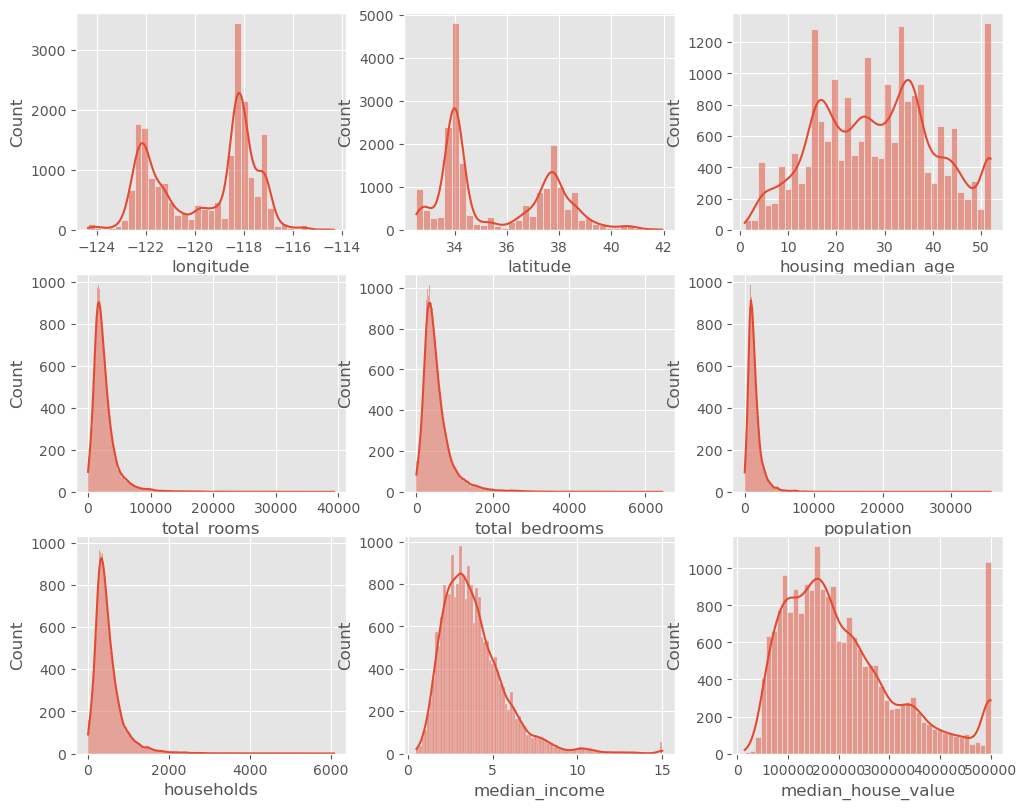

In [16]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows = 3, ncols = 3)    
axes = axes.flatten()         
fig.set_size_inches(10, 8)
plt.tight_layout()

for ax,c in zip(axes, pandas_df.columns):
      sns.histplot(pandas_df[c], ax = ax,kde=True)
plt.show()

### Veri seti train ve test diye ayırıldı. Kod her çalıştığında aynı bölünmeyi gerçekleştirmesi için _'seed'_ parametresi kullanıldı. 

In [17]:
splits = df.randomSplit([0.8, 0.2],seed=0)
train = splits[0]
test = splits[1]

In [18]:
print('Train veri setinin boyutu:',train.count())
train.show(10)

Train veri setinin boyutu: 16468
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|           94600.0|     NEAR OCEAN|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|           85800.0|     NEAR OCEAN|
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|          103600.0|     NEAR OCEAN|
|  -124.27|   40.69|              36.0|     2349.0|         528.0|    1194.0|     465.0|       2.5179|           79000.0|     NEAR OCEAN|
|

In [19]:
print('Test veri setinin boyutu:',test.count())
test.show(10)

Test veri setinin boyutu: 4172
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -124.18|   40.78|              37.0|     1453.0|         293.0|     867.0|     310.0|       2.5536|           70200.0|     NEAR OCEAN|
|  -124.18|   40.79|              39.0|     1836.0|         352.0|     883.0|     337.0|        1.745|           70500.0|     NEAR OCEAN|
|  -124.17|   40.78|              39.0|     1606.0|         330.0|     731.0|     327.0|       1.6369|           68300.0|     NEAR OCEAN|
|  -124.17|   40.79|              43.0|     2285.0|         479.0|    1169.0|     482.0|       1.9688|           70500.0|     NEAR OCEAN|
|  

### Train veri setinde column bazlı eksik değer adetleri:

In [20]:
print('Train dataframe'' indeki boş değerler')
null_counts = train.select([sum(col(c).isNull().cast("int")).alias(c) for c in train.columns])

null_counts.show()

Train dataframe indeki boş değerler
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           149|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



### Test veri setinde column bazlı eksik değer adetleri:

In [21]:
print('Test dataframe'' indeki boş değerler')
null_counts = test.select([sum(col(c).isNull().cast("int")).alias(c) for c in train.columns])

null_counts.show()

Test dataframe indeki boş değerler
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|            58|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



### Eksik değerleri heatmap ile görselleştirildi.

<Figure size 800x400 with 0 Axes>

<Axes: >

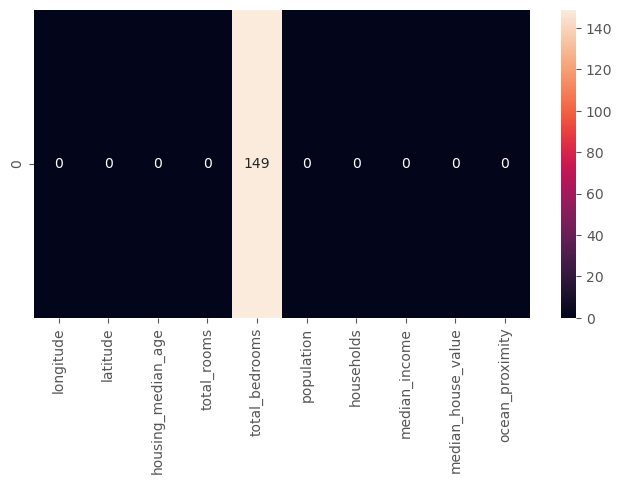

In [22]:
null_counts = [sum(col(c).isNull().cast("int")).alias(c) for c in train.columns]
nulls_df = train.select(null_counts).collect()[0].asDict()

nulls_pd_df = pd.DataFrame([nulls_df], columns=nulls_df.keys())

plt.figure(figsize=(8, 4))
sns.heatmap(nulls_pd_df, annot=True, fmt="d")
plt.show()

### Eksik değerlerin olduğu total_bedrooms column'unun ortalaması :

In [23]:
train.select('total_bedrooms').summary('mean').show()

+-------+-----------------+
|summary|   total_bedrooms|
+-------+-----------------+
|   mean|536.1552791224952|
+-------+-----------------+



### Eksik değerlerin olduğu total_bedrooms column'unun ortanca değeri:

In [24]:
median_approx = train.stat.approxQuantile("total_bedrooms", [0.5], 0.01)

print("Approximate median of total_bedrooms:", median_approx[0])

Approximate median of total_bedrooms: 433.0


# Özniteliklerin Seçimi ve Verilerin Makine Öğrenmesi için Hazırlanması

### Imputer sınıfını kullanarak total_bedrooms columunu, column'un median değerleriyle dolduruldu. Mean ile doldurmak da denendi. Median ile doldurarak daha iyi r'2 sonucu elde edildi. Doldurmuş değerlerin yazıldığı column: _total_bedrooms_imputed_.

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCol="total_bedrooms", 
    outputCol="total_bedrooms_imputed",
    strategy="median"
)
imputer = imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

### Boş değerlerin olduğu columnları veri setinden çıkarıldı. 

In [26]:
train.columns
train = train.drop('total_bedrooms')
test = test.drop('total_bedrooms')

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed']

### Boş değer var mı diye tekrardan kontrol edildi.

In [27]:
null_counts = train.select([sum(col(c).isNull().cast("int")).alias(c) for c in train.columns])

null_counts.show()

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+----------------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_imputed|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+----------------------+
|        0|       0|                 0|          0|         0|         0|            0|                 0|              0|                     0|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------------+----------------------+



### Veri setindeki aykırı değerleri  Interquartile range'e göre her column için sadece beş satır göstercek şekilde yazdırıldı. Bu sayede outlierlarla ilgili ön bilgi edinilmiş oldu. 

In [28]:
columns = ['longitude','latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms_imputed', 'population', 'households', 'median_income']

for column in columns:
    quantiles = train.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    print(f'Aykırı değerler {column}:')
    outliers.select(column).show(5)

Aykırı değerler longitude:
+---------+
|longitude|
+---------+
+---------+

Aykırı değerler latitude:
+--------+
|latitude|
+--------+
+--------+

Aykırı değerler housing_median_age:
+------------------+
|housing_median_age|
+------------------+
+------------------+

Aykırı değerler total_rooms:
+-----------+
|total_rooms|
+-----------+
|     5694.0|
|     5202.0|
|     5409.0|
|     5372.0|
|     6121.0|
+-----------+
only showing top 5 rows

Aykırı değerler total_bedrooms_imputed:
+----------------------+
|total_bedrooms_imputed|
+----------------------+
|                1056.0|
|                1222.0|
|                1088.0|
|                1104.0|
|                1112.0|
+----------------------+
only showing top 5 rows

Aykırı değerler population:
+----------+
|population|
+----------+
|    2907.0|
|    3546.0|
|    3002.0|
|    3595.0|
|    2967.0|
+----------+
only showing top 5 rows

Aykırı değerler households:
+----------+
|households|
+----------+
|     992.0|
|    1189.0|

### Outlierlara detaylı bakabilmek için boxplot ile görselleştirildi. Veri setinin logaritmasını kullanarak daha anlaşılır bir grafik elde elde edildi.

<Figure size 1700x600 with 0 Axes>

D:\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: >

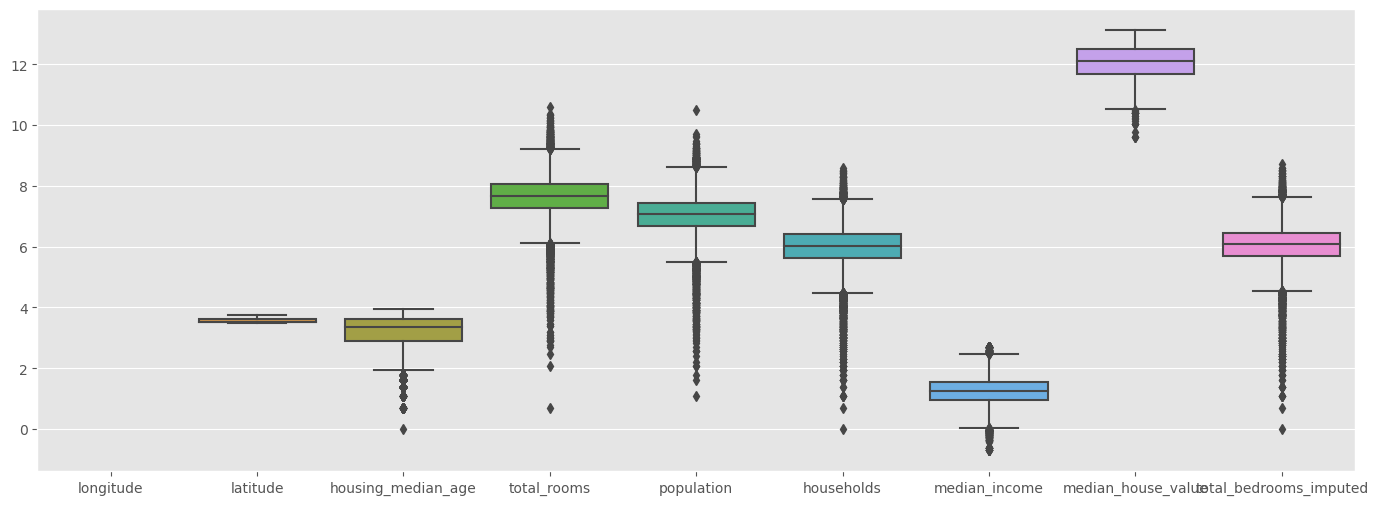

In [29]:
train_pd = train.toPandas()

plt.figure(figsize=(17,6))
train_pd.drop('ocean_proximity',axis=1, inplace=True)
sns.boxplot(np.log(train_pd))

### Outliersları belirlemek için bir fonksiyon kullanıldı. Fonksiyon, her sayısal column için _Q1_ ve _Q3_ değerlerini hesaplar, ardından bu değerleri kullanarak _IQR_ ve outlierslar için alt ve üst sınırları belirler. Her column için, hesaplanan sınırların dışında kalan değerler outliers olarak işaretlenir. Sonra, her satırdaki toplam outlier sayısı yeni bir columnda toplanır. Outliersları işaretleyen column temizlenir, böylece veri seti sadece orijinal sayısal columnlar ve her satır için toplam outlier değer sayısını gösteren bir column içerir.

In [30]:
from pyspark.sql import functions as F
from functools import reduce

def find_outliers(df):
    # Veri setimdeki sayısal columnlar.
    numeric_columns = ['longitude','latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms_imputed', 'population', 'households', 'median_income']

    # Her column'un ayrı ayrı Q1 ve Q3 değerlerirni hesaplar.
    for column in numeric_columns:
        # Q1 : First Quartile, Q3 : Third Quartile
        Q1 = df.approxQuantile(column, [0.25], relativeError=0)
        Q3 = df.approxQuantile(column, [0.75], relativeError=0)
        
        # IQR : Interquartile Range
        IQR = Q3[0] - Q1[0]
        
        # Sınır değerleri hesaplanır. 
        less_Q1 = Q1[0] - 1.5 * IQR
        more_Q3 = Q3[0] + 1.5 * IQR
        
        outlier_col = f'is_outlier_{column}'
        
        # Eğer column sütunundaki değer, üçüncü çeyreğin üst sınırından (more_Q3) büyükse veya birinci çeyreğin alt sınırından (less_Q1) küçükse, bu ifade 1 değerini döndürür, yani bu kaydı outlier olarak işaretler.
        df = df.withColumn(outlier_col, F.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    
    outlier_columns = [f'is_outlier_{column}' for column in numeric_columns]

    # Her column'daki outlier değerlerin toplamını total_outliers_col sütünunda toplar. 
    total_outliers_col = reduce(lambda x, y: x + y, (F.col(x) for x in outlier_columns))
    df = df.withColumn('total_outliers', total_outliers_col)

    # outlier_columns sütununu veri setinden atar. 
    df = df.drop(*outlier_columns)

    return df

### Fonksiyonu train ve test veri seti için çalıştırıldı. 

In [31]:
new_train = find_outliers(train)
new_test = find_outliers(test)

### Train veri seti için her satırdaki outlier değerlerin dağılımı:

In [32]:
outliers = new_train.groupBy("total_outliers").count().orderBy(col("count").desc())
outliers.show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0|14499|
|             1|  842|
|             4|  563|
|             2|  298|
|             3|  242|
|             5|   24|
+--------------+-----+



### Test veri seti için her satırdaki outlier değerlerin dağılımı:

In [33]:
outliers = new_test.groupBy("total_outliers").count().orderBy(col("count").desc())
outliers.show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0| 3673|
|             1|  217|
|             4|  154|
|             2|   64|
|             3|   63|
|             5|    1|
+--------------+-----+



### new_train veri setinden , total_outliers sütununda 1'den küçük veya eşit olan kayıtları filtreleyerek outlier değeri 1 veya daha az olan kayıtları içeren yeni bir veri seti oluşturuldu. Ardından, new_train ile aynı columnlara sahip, ancak outlier değer filtresinden geçmiş kayıtları içeren bir veri seti elde edildi. Hiç aykırı değerleri olmayan kayıtlar (_new_train[''total_outliers'']<=0_) seçildiğinde daha kötü bir r^2sonucu elde edildi. Bu yüzden en fazla 1 outliers değer içerebilen kayıtlarla devam edildi.

In [34]:
new_no_outliers = new_train.filter(new_train['total_outliers']<=1)
new_train_no_outliers = new_no_outliers.select(*new_train.columns)

new_train_no_outliers.columns #Kontrol etmek için columnlar yazdırıldı. 

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed',
 'total_outliers']

### Yukardaki işlemin aynısı test verisi için de yapıldı. 

In [35]:
new_no_outliers = new_test.filter(new_test['total_outliers']<=1)
new_test_no_outliers = new_no_outliers.select(*new_test.columns)

new_test_no_outliers.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed',
 'total_outliers']

In [36]:
print('Outlier''ları atmadan önce train verisinin boyutu: ',train.count())
print('Outlier''ları attıktan sonra train verisinin boyutu: ',new_train_no_outliers.count())

Outlierları atmadan önce train verisinin boyutu:  16468
Outlierları attıktan sonra train verisinin boyutu:  15341


In [37]:
print('Outlier''ları atmadan önce test verisinin boyutu: ',test.count())
print('Outlier''ları attıktan sonra test verisinin boyutu: ',new_test_no_outliers.count())

Outlierları atmadan önce test verisinin boyutu:  4172
Outlierları attıktan sonra test verisinin boyutu:  3890


### Son durumda outlier değerler box plot ile tekrar kontrol edildi. 

<Figure size 1700x600 with 0 Axes>

D:\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
D:\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
D:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: >

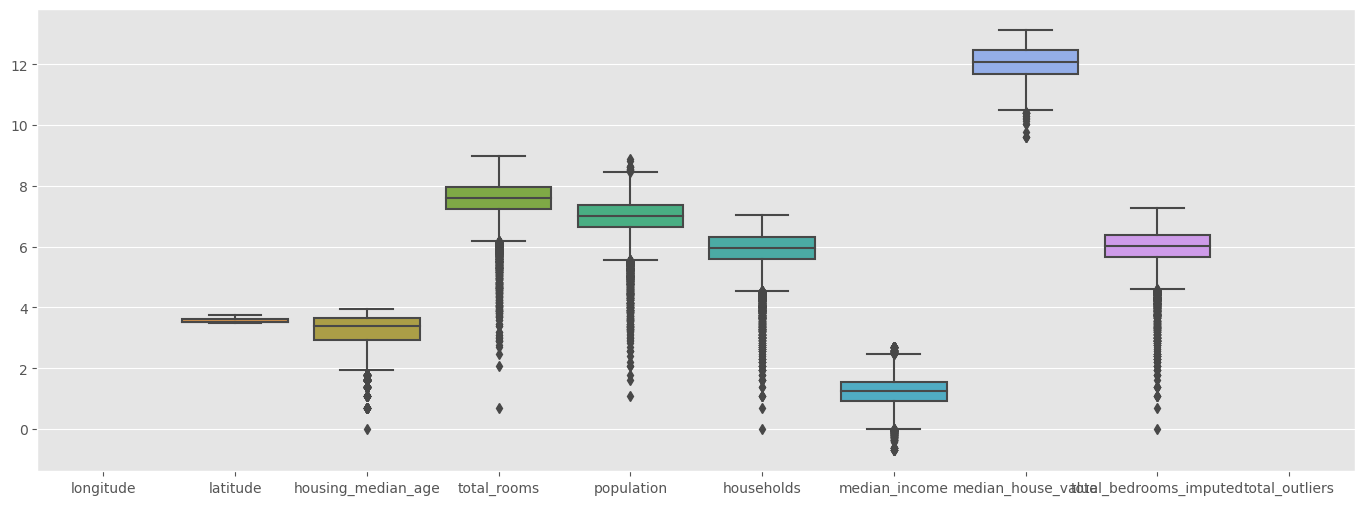

In [38]:
train_pd = new_train_no_outliers.toPandas()

plt.figure(figsize=(17,6))
train_pd.drop('ocean_proximity',axis=1, inplace=True)
sns.boxplot(np.log(train_pd))

In [39]:
#Variable isminde herhangi bir karışıklık olmaması için boyle devam ettim.
train = new_train_no_outliers
train = train.drop('total_outliers')

test = new_test_no_outliers
test = test.drop('total_outliers')

In [40]:
# Her hangi bir yanlışlık oldu mu diye kontrol ettim.
train.printSchema()
test.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms_imputed: double (nullable = true)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms_imputed: double (nullable = true)



### Spark SitringIndexer sınıfını  kullanarak ocean_proximity sütunundaki kategorik değerleri sayısal değerlere dönüştürüldü, sonra bu kategorik column eğitim ve test veri setlerinden çıkarıldı.

In [41]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_num")

train = indexer.fit(train).transform(train)
test = indexer.fit(test).transform(test)
train = train.drop('ocean_proximity')
test = test.drop('ocean_proximity')
train.show(10,truncate=False)

+---------+--------+------------------+-----------+----------+----------+-------------+------------------+----------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|total_bedrooms_imputed|ocean_proximity_num|
+---------+--------+------------------+-----------+----------+----------+-------------+------------------+----------------------+-------------------+
|-124.35  |40.54   |52.0              |1820.0     |806.0     |270.0     |3.0147       |94600.0           |300.0                 |2.0                |
|-124.3   |41.8    |19.0              |2672.0     |1298.0    |478.0     |1.9797       |85800.0           |552.0                 |2.0                |
|-124.3   |41.84   |17.0              |2677.0     |1244.0    |456.0     |3.0313       |103600.0          |531.0                 |2.0                |
|-124.27  |40.69   |36.0              |2349.0     |1194.0    |465.0     |2.5179       |79000.0      

###  Hem train hem de test veri kümelerinde belirtilen columnlardan özellik vektörleri oluşturmak için Spark ML'nin VectorAssemblerını kullanıldı. Makine öğrenimi modelleri Spark'ta verilerin bu formatda sunulmasını gerektirir çünkü modeller eğitim veya tahmin için tek bir vektör sütunu kullanır. Sonuç vektör column'unun adı 'features' olarak adlandırıldı.

In [42]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['longitude','latitude','housing_median_age','total_rooms','population','households','median_income','total_bedrooms_imputed','ocean_proximity_num'],outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)
train.select("features").show(5,truncate=False)
test.select("features").show(5,truncate=False)

+---------------------------------------------------------+
|features                                                 |
+---------------------------------------------------------+
|[-124.35,40.54,52.0,1820.0,806.0,270.0,3.0147,300.0,2.0] |
|[-124.3,41.8,19.0,2672.0,1298.0,478.0,1.9797,552.0,2.0]  |
|[-124.3,41.84,17.0,2677.0,1244.0,456.0,3.0313,531.0,2.0] |
|[-124.27,40.69,36.0,2349.0,1194.0,465.0,2.5179,528.0,2.0]|
|[-124.26,40.58,52.0,2217.0,907.0,369.0,2.3571,394.0,2.0] |
+---------------------------------------------------------+
only showing top 5 rows

+---------------------------------------------------------+
|features                                                 |
+---------------------------------------------------------+
|[-124.18,40.78,37.0,1453.0,867.0,310.0,2.5536,293.0,2.0] |
|[-124.18,40.79,39.0,1836.0,883.0,337.0,1.745,352.0,2.0]  |
|[-124.17,40.78,39.0,1606.0,731.0,327.0,1.6369,330.0,2.0] |
|[-124.17,40.79,43.0,2285.0,1169.0,482.0,1.9688,479.0,2.0]|
|[-124.17,40.8,

### RobustScaler kullanarak train ve test veri setlerindeki özellik vektörlerini (features) ölçeklendirir. RobustScaler, özellikle aykırı değerlerden etkilenmeyecek şekilde tasarlanmış bir ölçeklendirme yöntemidir ve bu yüzden seçilmiştir. Diğer standartlaştırma yöntemleri (standartscaler,minmaxscaler) denendiğinde daha düşük r^2 sonuçları alındığından robust scaler kullanıldı. 

In [43]:
from pyspark.ml.feature import RobustScaler

scaler = RobustScaler(inputCol="features", outputCol="scaled_features") 
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)
train.select("features", "scaled_features").show(truncate=30)
test.select("features", "scaled_features").show(truncate=30)

+------------------------------+------------------------------+
|                      features|               scaled_features|
+------------------------------+------------------------------+
|[-124.35,40.54,52.0,1820.0,...|[-32.896825396825385,10.696...|
|[-124.3,41.8,19.0,2672.0,12...|[-32.88359788359787,11.0290...|
|[-124.3,41.84,17.0,2677.0,1...|[-32.88359788359787,11.0395...|
|[-124.27,40.69,36.0,2349.0,...|[-32.875661375661366,10.736...|
|[-124.26,40.58,52.0,2217.0,...|[-32.873015873015866,10.707...|
|[-124.25,40.28,32.0,1430.0,...|[-32.87037037037036,10.6279...|
|[-124.23,40.54,52.0,2694.0,...|[-32.86507936507936,10.6965...|
|[-124.23,40.81,52.0,1112.0,...|[-32.86507936507936,10.7678...|
|[-124.23,41.75,11.0,3159.0,...|[-32.86507936507936,11.0158...|
|[-124.22,41.73,28.0,3003.0,...|[-32.86243386243385,11.0105...|
|[-124.21,40.75,32.0,1218.0,...|[-32.85978835978835,10.7519...|
|[-124.21,41.75,20.0,3810.0,...|[-32.85978835978835,11.0158...|
|[-124.21,41.77,17.0,3461.0,...|[-32.859

### Train veri setinin korelasyon matrisi hesaplandı.

In [44]:
from pyspark.ml.stat import Correlation

correlation_matrix = Correlation.corr(train, "scaled_features").head()
correlation_matrix

Row(pearson(scaled_features)=DenseMatrix(9, 9, [1.0, -0.9249, -0.0954, 0.0049, 0.1146, 0.0371, -0.0066, 0.0425, ..., 0.388, 0.1415, -0.0105, -0.1128, -0.0189, -0.0494, -0.0072, 1.0], False))

### Veri setindeki longitude ve latitude columnları arasında bir heatmap ile görselleştirme yapılarak yüksek korelasyon tespit edildi.Bu durumun modelin performansını etkileyip etkilemeyeceğini değerlendirmek için, bu sütunlardan birinin veri setinden çıkarılması denendi. Ancak, bu değişiklik modelin r^2 değerini iyileştirmedi,her iki column da veri setinde tutulmaya karar verildi.

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Feature Correlation Matrix')

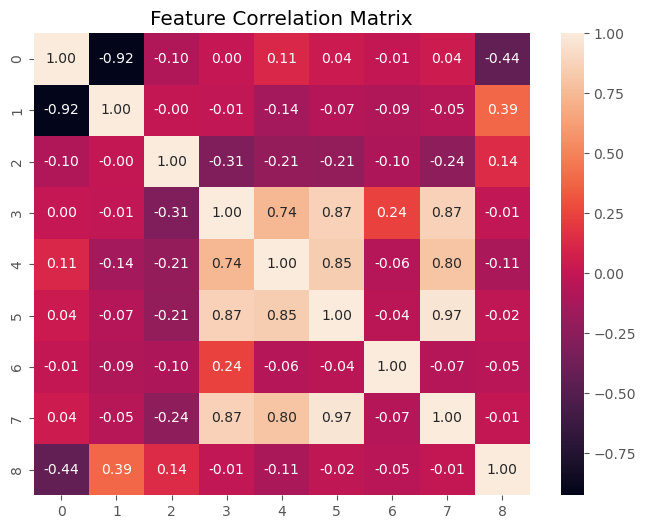

In [45]:
correlation_matrix_np = correlation_matrix[0].toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_np, annot=True,fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

### Varyansa göre featureselection denendi. VarianceThresholdSelector sınıfı, belirlenen bir eşikten daha düşük varyansa sahip, yani pek değişkenlik göstermeyen özellikleri elemeyi sağlar. Threshold a göre bir column bile çıkarıldığında r^2 değerinde düşme oldu. Bu yüzden kullanılmadı. 

In [46]:
"""
from pyspark.ml.feature import  VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=0.30, featuresCol="scaled_features",
                                     outputCol="selected_features")
train = selector.fit(train).transform(train)
test = selector.fit(test).transform(test)
train.select("selected_features").show(5,truncate=False)
test.select("selected_features").show(5,truncate=False)

"""

'\nfrom pyspark.ml.feature import  VarianceThresholdSelector\n\nselector = VarianceThresholdSelector(varianceThreshold=0.30, featuresCol="scaled_features",\n                                     outputCol="selected_features")\ntrain = selector.fit(train).transform(train)\ntest = selector.fit(test).transform(test)\ntrain.select("selected_features").show(5,truncate=False)\ntest.select("selected_features").show(5,truncate=False)\n\n'

# PySpark ile Makine Öğrenmesi Modelinin Oluşturulması

### LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor ve Lasso regresyonu (Elastic Net parametresi elasticNetParam=1 ile LinearRegression) dahil olmak üzere bu modellere göre r^2 değeri hesaplanarak en iyi r^2değerini veren modelin hangisi olduğu belirlenir.

In [47]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

models = [
    LinearRegression(featuresCol='scaled_features', labelCol='median_house_value'),
    DecisionTreeRegressor(featuresCol='scaled_features', labelCol='median_house_value'),
    RandomForestRegressor(featuresCol='scaled_features', labelCol='median_house_value'),
    GBTRegressor(featuresCol='scaled_features', labelCol='median_house_value'),
    LinearRegression(featuresCol='scaled_features', labelCol='median_house_value', elasticNetParam=1, regParam=0.01),#Lasso
]

best_model = None
best_r2 = 0.0 

for model in models:
    model_name = model.__class__.__name__
    
    fitted_model = model.fit(train)
    
    train_predictions = fitted_model.transform(train)
    train_evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
    train_r2 = train_evaluator_r2.evaluate(train_predictions)
 
    test_predictions = fitted_model.transform(test)
    test_evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
    test_r2 = test_evaluator_r2.evaluate(test_predictions)
  
    print(f"{model_name} modeli için:")
    print(f"  Eğitim Veri Seti R2 Değeri: {train_r2}")
    print(f"  Test Veri Seti R2 Değeri: {test_r2}\n")

    if test_r2 > best_r2:
        best_r2 = test_r2
        best_model = fitted_model

print(f"En iyi model: {best_model.__class__.__name__} ile Test Veri Seti R^2 Değeri: {best_r2}")


LinearRegression modeli için:
  Eğitim Veri Seti R2 Değeri: 0.6435617222699299
  Test Veri Seti R2 Değeri: 0.6507547126804435

DecisionTreeRegressor modeli için:
  Eğitim Veri Seti R2 Değeri: 0.6267669432709341
  Test Veri Seti R2 Değeri: 0.6429018735737255

RandomForestRegressor modeli için:
  Eğitim Veri Seti R2 Değeri: 0.6446778702219861
  Test Veri Seti R2 Değeri: 0.6571563133358249

GBTRegressor modeli için:
  Eğitim Veri Seti R2 Değeri: 0.772693150767457
  Test Veri Seti R2 Değeri: 0.7638757421088391

LinearRegression modeli için:
  Eğitim Veri Seti R2 Değeri: 0.6435616664977415
  Test Veri Seti R2 Değeri: 0.6507382356374569

En iyi model: GBTRegressionModel ile Test Veri Seti R^2 Değeri: 0.7638757421088391


### Aşağıdaki kod, Gradient-Boosted Trees (GBT) regresyon modelini optimize etmek için parametre ayarlama ve cross-validation işlemlerini gerçekleştirir. ParamGridBuilder: Modelin performansını farklı parametre kombinasyonlarıyla değerlendirmek için kullanılır. CrossValidator: Model seçimi ve hiperparametre ayarlaması için kullanılan çapraz doğrulama yöntemidir. numFolds=5 ile veri seti 5 parçaya ayrılır ve her seferinde bir parça test seti olarak kullanılırken, kalanlar eğitim seti olarak kullanılır.

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

gbt = GBTRegressor(featuresCol='scaled_features', labelCol='median_house_value')

paramGrid = (ParamGridBuilder() # .addGrid(): Model parametrelerinin alabileceği değerlerin listesini belirlemek için kullanılır. 
             .addGrid(gbt.maxDepth, [2, 4, 5, 6]) # Ağacın maksimum derinliğii
             .addGrid(gbt.maxBins, [32, 64]) #  Karar ağacında bir özellik için kullanılabilecek maksimum bin sayısı. Bu, continuous özelliklerin nasıl bölündüğünü etkiler. 
             .addGrid(gbt.stepSize, [0.01, 0.05]) # Her iterasyonda model ağırlıklarının ne kadar güncelleneceğini belirler.
             .addGrid(gbt.maxIter, [20, 30, 40])  # Modelin eğitim için kullanacağı toplam iterasyon (döngü) sayısı.
             .build())

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='r2')

cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5) # 5 katlı cross validation  
cvModel = cv.fit(train)

predictions = cvModel.transform(test)

r2 = evaluator.evaluate(predictions)
print('Test seti üzerindeki en iyi modelin R^2 değeri: ', r2)

bestModel = cvModel.bestModel
print('En iyi modelin parametreleri:')
print(f'  - maxDepth: {bestModel._java_obj.getMaxDepth()}')
print(f'  - maxBins: {bestModel._java_obj.getMaxBins()}')
print(f'  - stepSize: {bestModel._java_obj.getStepSize()}')
print(f'  - maxIter: {bestModel._java_obj.getMaxIter()}')

Test seti üzerindeki en iyi modelin R^2 değeri:  0.7774787466229991
En iyi modelin parametreleri:
  - maxDepth: 6
  - maxBins: 64
  - stepSize: 0.05
  - maxIter: 40


In [49]:
predicted = predictions.select("scaled_features", "prediction", "median_house_value")
predicted.show(10,truncate=20)

+--------------------+------------------+------------------+
|     scaled_features|        prediction|median_house_value|
+--------------------+------------------+------------------+
|[-32.851851851851...| 86207.84941112762|           70200.0|
|[-32.851851851851...|101363.85146774758|           70500.0|
|[-32.849206349206...|102676.48808546385|           68300.0|
|[-32.849206349206...| 103395.9593633806|           70500.0|
|[-32.849206349206...|122438.20604077342|           60000.0|
|[-32.846560846560...| 95826.19789398486|           85600.0|
|[-32.846560846560...| 114232.8176316082|           82000.0|
|[-32.846560846560...| 97619.99105963606|           85400.0|
|[-32.846560846560...|120323.22116608021|           75000.0|
|[-32.843915343915...| 83307.22550074599|          104200.0|
+--------------------+------------------+------------------+
only showing top 10 rows



<Axes: xlabel='median_house_value', ylabel='prediction'>

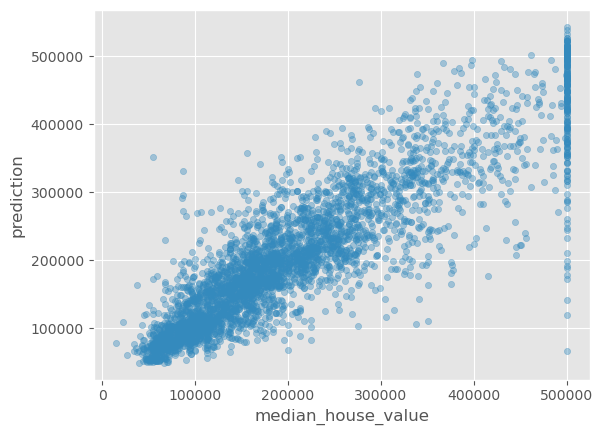

In [50]:
predicted = predicted.toPandas()
predicted.plot.scatter(x='median_house_value', y='prediction', alpha = 0.4)

# Geliştirilen Modelin Performansının Ölçümü

In [51]:
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", 
metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Square Error (RMSE):", rmse)

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", 
metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R^2:", r2)

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", 
metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error:", mae)

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", 
metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error:", mse)

Root Mean Square Error (RMSE): 55444.68478750848
R^2: 0.7774787466229991
Mean Absolute Error: 37952.11628379425
Mean Squared Error: 3074113071.186174


# BONUS

### Eğitim verilerine uygulanan yöntemler tüm veriler için uygulandı. Model son aşama olarak tüm verilerle eğitildi. 

In [52]:
from pyspark.ml import Pipeline

df = spark.read.csv('housing.csv',header=True, inferSchema=True)

imputer = Imputer(
    inputCol="total_bedrooms", 
    outputCol="total_bedrooms_imputed",
    strategy="median"
)
imputer = imputer.fit(df)
df = imputer.transform(df)

df = df.drop('total_bedrooms')
new_df = find_outliers(df)

new_no_outliers = new_df.filter(new_df['total_outliers']<=1)
new_df_no_outliers = new_no_outliers.select(*new_df.columns)

df=new_df_no_outliers

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_num")
assembler = VectorAssembler(inputCols=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'total_bedrooms_imputed', 'ocean_proximity_num'], outputCol='features')
scaler = RobustScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[indexer, assembler, scaler])
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df) 

gbtRegressor = GBTRegressor(featuresCol='scaled_features', labelCol='median_house_value', maxDepth=6, maxBins=64, stepSize=0.05, maxIter=40)

model = gbtRegressor.fit(df) # Model hazır.

In [53]:
model

GBTRegressionModel: uid=GBTRegressor_d090e8e520af, numTrees=40, numFeatures=9

In [54]:
spark.stop()